In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# import lightgbm as lgb
from functools import partial

import os 
import gc
from scipy.sparse import vstack  
import time
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
import seaborn as sns 

### 加载数据


In [ ]:
from tqdm import tqdm
from tqdm import tqdm_notebook

path ='/Users/lhc456/Desktop/python/Data-Analyse/时间序列数据处理/input/'
for i in tqdm(range(1,26)):
    if i < 10:
        train_tmp = pd.read_csv(path + 'Metro_train/record_2019-01-0' + str(i) + '.csv')
    else:
        train_tmp = pd.read_csv(path + 'Metro_train/record_2019-01-' + str(i) + '.csv')
    if i== 1:
        data = train_tmp
    else:
        data = pd.concat([data, train_tmp],axis=0,ignore_index=True) 
        
Metro_roadMap = pd.read_csv(path + 'Metro_roadMap.csv')

test_A_record = pd.read_csv(path + 'Metro_testA/testA_record_2019-01-28.csv') 
test_A_submit = pd.read_csv(path + 'Metro_testA/testA_submit_2019-01-29.csv') 

data = pd.concat([data, test_A_record],axis=0,ignore_index=True)

In [ ]:
data.head()


In [ ]:
data.info()


In [ ]:
def trans_time_10_minutes(x):
    x_split = x.split(':')
    x_part1 = x_split[0]
    x_part2 = int(x_split[1]) // 10
    if x_part2 == 0:
        x_part2 = '00'
    else:
        x_part2 = str(x_part2 * 10)
    return x_part1 + ':' + x_part2 + ':00'

In [ ]:
# 知识点：时间转换，apply应用
data['time'] = pd.to_datetime(data['time'])
data['time_10_minutes'] = data['time'].astype(str).apply(lambda x: trans_time_10_minutes(x))

In [ ]:
data.head()


In [ ]:
# 知识点：groupby聚合
data_inNums = data[data.status == 1].groupby(['stationID','time_10_minutes']).size().to_frame('inNums').reset_index()
data_inNums.head() 

In [ ]:
data_outNums = data[data.status == 0].groupby(['stationID','time_10_minutes']).size().to_frame('outNums').reset_index()
data_outNums.head() 

In [ ]:
stationIDs = test_A_submit['stationID'].unique()
times = [] 
days = [i for i in range(1,26)] + [28, 29]
for day in days: 
    if day < 10:
        day_str = '0' + str(day)
    else:
        day_str = str(day)
    for hour in range(24):
        if hour < 10:
            hour_str = '0' + str(hour)
        else:
            hour_str = str(hour)
        for minutes in range(6):
            if minutes == 0:
                minutes_str = '0' + str(minutes)
            else:
                minutes_str = str(minutes * 10) 
            times.append('2019-01-' + day_str + ' ' + hour_str +':' + minutes_str + ':00')

# 知识点：求笛卡儿积
from itertools import product
stationids_by_times = list(product(stationIDs, times))
# 构建新的数据集
df_data = pd.DataFrame()
df_data['stationID'] = np.array(stationids_by_times)[:,0]
df_data['startTime'] = np.array(stationids_by_times)[:,1]
# 知识点：sort排序
df_data = df_data.sort_values(['stationID','startTime'])
df_data['endTime'] = df_data.groupby('stationID')['startTime'].shift(-1).values

In [ ]:
df_data

In [ ]:
def filltime(x):
    x_split = x.split(' ')[0].split('-')
    x_part1_1 = x_split[0] +'-'+x_split[1]+'-'
    x_part1_2 = int(x_split[2]) + 1
    if x_part1_2 < 10:
        x_part1_2 = '0' + str(x_part1_2)
    else:
        x_part1_2 = str(x_part1_2)
        
    x_part2 = ' 00:00:00'
    return x_part1_1 + x_part1_2 + x_part2
# 知识点：缺失值时间填充
df_data.loc[df_data.endTime.isnull(), 'endTime']  = \
df_data.loc[df_data.endTime.isnull(), 'startTime'].apply(lambda x: filltime(x)) 
df_data['stationID'] = df_data['stationID'].astype(int)

In [ ]:
df_data

In [ ]:
data_inNums.rename(columns={'time_10_minutes':'startTime'}, inplace=True)
data_outNums.rename( columns={'time_10_minutes':'startTime'}, inplace=True)

# 知识点：数据合并
df_data = df_data.merge(data_inNums , on=['stationID', 'startTime'], how='left')
df_data = df_data.merge(data_outNums, on=['stationID', 'startTime'], how='left')
df_data['inNums']  = df_data['inNums'].fillna(0)
df_data['outNums'] = df_data['outNums'].fillna(0)


In [ ]:
# 知识点：时间相关特征
df_data['time'] = pd.to_datetime(df_data['startTime'])
df_data['day'] = df_data['time'].dt.day  
df_data['hours_in_day'] = df_data['time'].dt.hour 
df_data['day_of_week'] = df_data['time'].dt.dayofweek 
df_data['ten_minutes_in_day'] = df_data['hours_in_day'] * 6 + df_data['time'].dt.minute // 10 
del df_data['time']

In [ ]:
df_data


### 时间序列数据可视化操作


In [ ]:
tmp = df_data[df_data.day==1]
dt = [r for r in range(tmp.loc[tmp.stationID==0, 'ten_minutes_in_day'].shape[0])]

fig = plt.figure(1,figsize=[12,6])
plt.ylabel('inNums',fontsize=14)
plt.xlabel('date',fontsize=14)
# plt.title('inNums of stationID ')

for i in range(0,10):
    plt.plot(dt, tmp.loc[tmp.stationID==i, 'inNums'], label = str(i)+' stationID' )
    
plt.legend(fontsize=14)

In [ ]:
tmp = df_data[df_data.day==1]
dt = [r for r in range(tmp.loc[tmp.stationID==0, 'ten_minutes_in_day'].shape[0])]

fig = plt.figure(1,figsize=[12,6])
plt.ylabel('outNums',fontsize=14)
plt.xlabel('date',fontsize=14)
# plt.title('outNums of stationID ')

for i in range(0,10):
    plt.plot(dt, tmp.loc[tmp.stationID==i, 'outNums'], label = str(i)+' stationID' )
    
plt.legend(fontsize=14)


In [ ]:
tmp = df_data[df_data.day==3]
dt = [r for r in range(tmp.loc[tmp.stationID==0, 'ten_minutes_in_day'].shape[0])]

fig = plt.figure(1,figsize=[20,10])
plt.ylabel('outNums')
plt.xlabel('date')
plt.title('outNums of stationID ')

for i in range(0,10):
    plt.plot(dt, tmp.loc[tmp.stationID==i, 'outNums'], label = str(i)+' stationID' )
    
plt.legend()
plt.show()

In [ ]:
tmp = df_data[df_data.day==5]
dt = [r for r in range(tmp.loc[tmp.stationID==0, 'ten_minutes_in_day'].shape[0])]

fig = plt.figure(1,figsize=[20,10])
plt.ylabel('outNums')
plt.xlabel('date')
plt.title('outNums of stationID ')

for i in range(0,10):
    plt.plot(dt, tmp.loc[tmp.stationID==i, 'outNums'], label = str(i)+' stationID' )
    
plt.legend()
plt.show()

In [ ]:
tmp = df_data[df_data.day>=1]
dt = [r for r in range(tmp.loc[tmp.stationID==0, 'ten_minutes_in_day'].shape[0])]

fig = plt.figure(1,figsize=[12,6])
plt.ylabel('inNums',fontsize=14)
plt.xlabel('date',fontsize=14)
# plt.title('inNums of stationID ')

for i in range(0,10):
    plt.plot(dt, tmp.loc[tmp.stationID==i, 'inNums'], label = str(i)+' stationID' )
    
plt.legend()

周期性比较强，围绕着天进行，或者周



In [ ]:
tmp = df_data.loc[(df_data.day.isin([4,5]))] # 4为周内，5为周末
tmp.loc[tmp.stationID == 4].pivot_table(index='hours_in_day',\
                                        columns='day',values='inNums').plot(style='o-')

plt.ylabel('inNums',fontsize=14)
plt.xlabel('hour',fontsize=14)
plt.legend(fontsize=14)

In [ ]:
tmp = df_data.loc[(df_data.day.isin([3,4]))]
tmp.loc[tmp.stationID == 4].pivot_table(index='hours_in_day',\
                                        columns='day',values='inNums').plot(style='o-')

plt.ylabel('inNums',fontsize=14)
plt.xlabel('hour',fontsize=14)
plt.legend(fontsize=14)

In [ ]:
df_data.loc[df_data.day==1, 'day'] = '元旦'


In [ ]:
plt.rcParams['font.sans-serif'] = ['Heiti TC']
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
tmp = df_data.loc[(df_data.day.isin(['元旦',2,3,4]))]
tmp.loc[tmp.stationID == 4].pivot_table(index='hours_in_day',\
                                        columns='day',values='inNums').plot(style='o-')

plt.ylabel('inNums',fontsize=14)
plt.xlabel('hour',fontsize=14)
plt.legend(fontsize=14)
plt.savefig("10_inNums_of_day1234.svg", format="svg")

In [ ]:
# 剔除与测试集分布差异大的日期
df_data = df_data.loc[((df_data.day_of_week < 5) & (df_data.day != 1))].copy()
# 保留日期
retain_days = list(df_data.day.unique())
# 重新计算rank，方便我们后续提取特征
days_relative = {} 
for i,d in enumerate(retain_days):
    days_relative[d] = i + 1

df_data['days_relative'] = df_data['day'].map(days_relative)

#### 可视化代码 ####
dt = [r for r in range(df_data.loc[df_data.stationID==0, 
    'ten_minutes_in_day'].shape[0])]
fig = plt.figure(1,figsize=[12,6])
plt.ylabel('inNums',fontsize=14)
plt.xlabel('date',fontsize=14)

for i in range(0,10):
    plt.plot(dt, df_data.loc[df_data.stationID==i, 'inNums'], label = str(i)+' stationID' )  
plt.legend()

In [18]:
data.head()


,time,lineID,stationID,deviceID,status,userID,payType,time_10_minutes
0,2019-01-01 02:00:05,B,27,1354,0,D13f76f42c9a677c4add94d9e480fb5c5,3,2019-01-01 02:00:00
1,2019-01-01 02:01:40,B,5,200,1,D9a337d37d9512184b8e3fd477934b293,3,2019-01-01 02:00:00
2,2019-01-01 02:01:53,B,5,247,0,Dc9e179298617f40b782490c1f3e2346c,3,2019-01-01 02:00:00
3,2019-01-01 02:02:38,B,5,235,0,D9a337d37d9512184b8e3fd477934b293,3,2019-01-01 02:00:00
4,2019-01-01 02:03:42,B,23,1198,0,Dd1cde61886c23fdb7ef1fdb76c9b1234,3,2019-01-01 02:00:00


In [19]:
# 知识点：groupby聚合
data_inNums = data[data.status == 1].groupby(['stationID','time_10_minutes']).size().to_frame('inNums').reset_index()
data_inNums.head() 

,stationID,time_10_minutes,inNums
0,0,2019-01-01 05:30:00,1
1,0,2019-01-01 05:40:00,4
2,0,2019-01-01 05:50:00,3
3,0,2019-01-01 06:00:00,17
4,0,2019-01-01 06:10:00,21


In [20]:
data_outNums = data[data.status == 0].groupby(['stationID','time_10_minutes']).size().to_frame('outNums').reset_index()
data_outNums.head() 

,stationID,time_10_minutes,outNums
0,0,2019-01-01 05:50:00,1
1,0,2019-01-01 06:20:00,1
2,0,2019-01-01 06:30:00,49
3,0,2019-01-01 06:40:00,48
4,0,2019-01-01 06:50:00,25


In [21]:
stationIDs = test_A_submit['stationID'].unique()
times = [] 
days = [i for i in range(1,26)] + [28, 29]
for day in days: 
    if day < 10:
        day_str = '0' + str(day)
    else:
        day_str = str(day)
    for hour in range(24):
        if hour < 10:
            hour_str = '0' + str(hour)
        else:
            hour_str = str(hour)
        for minutes in range(6):
            if minutes == 0:
                minutes_str = '0' + str(minutes)
            else:
                minutes_str = str(minutes * 10) 
            times.append('2019-01-' + day_str + ' ' + hour_str +':' + minutes_str + ':00')

# 知识点：求笛卡儿积
from itertools import product
stationids_by_times = list(product(stationIDs, times))
# 构建新的数据集
df_data = pd.DataFrame()
df_data['stationID'] = np.array(stationids_by_times)[:,0]
df_data['startTime'] = np.array(stationids_by_times)[:,1]
# 知识点：sort排序
df_data = df_data.sort_values(['stationID','startTime'])
df_data['endTime'] = df_data.groupby('stationID')['startTime'].shift(-1).values

In [22]:
df_data

,stationID,startTime,endTime
0,0,2019-01-01 00:00:00,2019-01-01 00:10:00
1,0,2019-01-01 00:10:00,2019-01-01 00:20:00
2,0,2019-01-01 00:20:00,2019-01-01 00:30:00
3,0,2019-01-01 00:30:00,2019-01-01 00:40:00
4,0,2019-01-01 00:40:00,2019-01-01 00:50:00
...,...,...,...
38875,9,2019-01-29 23:10:00,2019-01-29 23:20:00
38876,9,2019-01-29 23:20:00,2019-01-29 23:30:00
38877,9,2019-01-29 23:30:00,2019-01-29 23:40:00
38878,9,2019-01-29 23:40:00,2019-01-29 23:50:00


In [23]:
def filltime(x):
    x_split = x.split(' ')[0].split('-')
    x_part1_1 = x_split[0] +'-'+x_split[1]+'-'
    x_part1_2 = int(x_split[2]) + 1
    if x_part1_2 < 10:
        x_part1_2 = '0' + str(x_part1_2)
    else:
        x_part1_2 = str(x_part1_2)
        
    x_part2 = ' 00:00:00'
    return x_part1_1 + x_part1_2 + x_part2
# 知识点：缺失值时间填充
df_data.loc[df_data.endTime.isnull(), 'endTime']  = \
df_data.loc[df_data.endTime.isnull(), 'startTime'].apply(lambda x: filltime(x)) 
df_data['stationID'] = df_data['stationID'].astype(int)

In [24]:
df_data

,stationID,startTime,endTime
0,0,2019-01-01 00:00:00,2019-01-01 00:10:00
1,0,2019-01-01 00:10:00,2019-01-01 00:20:00
2,0,2019-01-01 00:20:00,2019-01-01 00:30:00
3,0,2019-01-01 00:30:00,2019-01-01 00:40:00
4,0,2019-01-01 00:40:00,2019-01-01 00:50:00
...,...,...,...
38875,9,2019-01-29 23:10:00,2019-01-29 23:20:00
38876,9,2019-01-29 23:20:00,2019-01-29 23:30:00
38877,9,2019-01-29 23:30:00,2019-01-29 23:40:00
38878,9,2019-01-29 23:40:00,2019-01-29 23:50:00


In [25]:
data_inNums.rename(columns={'time_10_minutes':'startTime'}, inplace=True)
data_outNums.rename( columns={'time_10_minutes':'startTime'}, inplace=True)

# 知识点：数据合并
df_data = df_data.merge(data_inNums , on=['stationID', 'startTime'], how='left')
df_data = df_data.merge(data_outNums, on=['stationID', 'startTime'], how='left')
df_data['inNums']  = df_data['inNums'].fillna(0)
df_data['outNums'] = df_data['outNums'].fillna(0)


In [26]:
# 知识点：时间相关特征
df_data['time'] = pd.to_datetime(df_data['startTime'])
df_data['day'] = df_data['time'].dt.day  
df_data['hours_in_day'] = df_data['time'].dt.hour 
df_data['day_of_week'] = df_data['time'].dt.dayofweek 
df_data['ten_minutes_in_day'] = df_data['hours_in_day'] * 6 + df_data['time'].dt.minute // 10 
del df_data['time']

In [27]:
df_data


,stationID,startTime,endTime,inNums,outNums,day,hours_in_day,day_of_week,ten_minutes_in_day
0,0,2019-01-01 00:00:00,2019-01-01 00:10:00,0.0,0.0,1,0,1,0
1,0,2019-01-01 00:10:00,2019-01-01 00:20:00,0.0,0.0,1,0,1,1
2,0,2019-01-01 00:20:00,2019-01-01 00:30:00,0.0,0.0,1,0,1,2
3,0,2019-01-01 00:30:00,2019-01-01 00:40:00,0.0,0.0,1,0,1,3
4,0,2019-01-01 00:40:00,2019-01-01 00:50:00,0.0,0.0,1,0,1,4
...,...,...,...,...,...,...,...,...,...
314923,9,2019-01-29 23:10:00,2019-01-29 23:20:00,0.0,0.0,29,23,1,139
314924,9,2019-01-29 23:20:00,2019-01-29 23:30:00,0.0,0.0,29,23,1,140
314925,9,2019-01-29 23:30:00,2019-01-29 23:40:00,0.0,0.0,29,23,1,141
314926,9,2019-01-29 23:40:00,2019-01-29 23:50:00,0.0,0.0,29,23,1,142


### 时间序列数据可视化操作


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


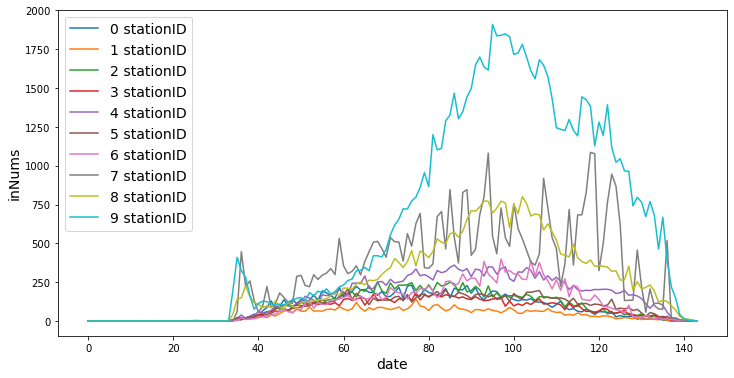

In [28]:
tmp = df_data[df_data.day==1]
dt = [r for r in range(tmp.loc[tmp.stationID==0, 'ten_minutes_in_day'].shape[0])]

fig = plt.figure(1,figsize=[12,6])
plt.ylabel('inNums',fontsize=14)
plt.xlabel('date',fontsize=14)
# plt.title('inNums of stationID ')

for i in range(0,10):
    plt.plot(dt, tmp.loc[tmp.stationID==i, 'inNums'], label = str(i)+' stationID' )
    
plt.legend(fontsize=14)

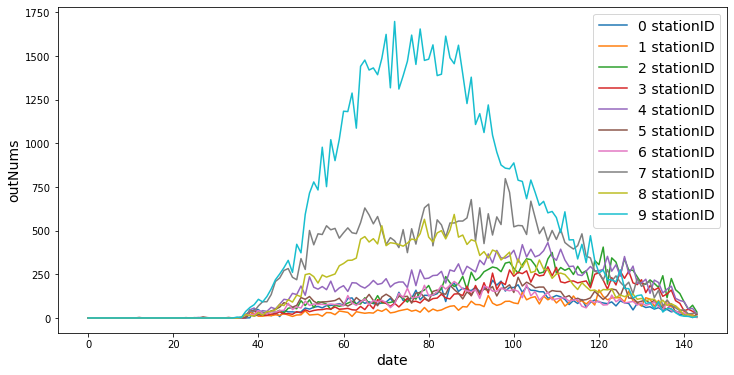

In [29]:
tmp = df_data[df_data.day==1]
dt = [r for r in range(tmp.loc[tmp.stationID==0, 'ten_minutes_in_day'].shape[0])]

fig = plt.figure(1,figsize=[12,6])
plt.ylabel('outNums',fontsize=14)
plt.xlabel('date',fontsize=14)
# plt.title('outNums of stationID ')

for i in range(0,10):
    plt.plot(dt, tmp.loc[tmp.stationID==i, 'outNums'], label = str(i)+' stationID' )
    
plt.legend(fontsize=14)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


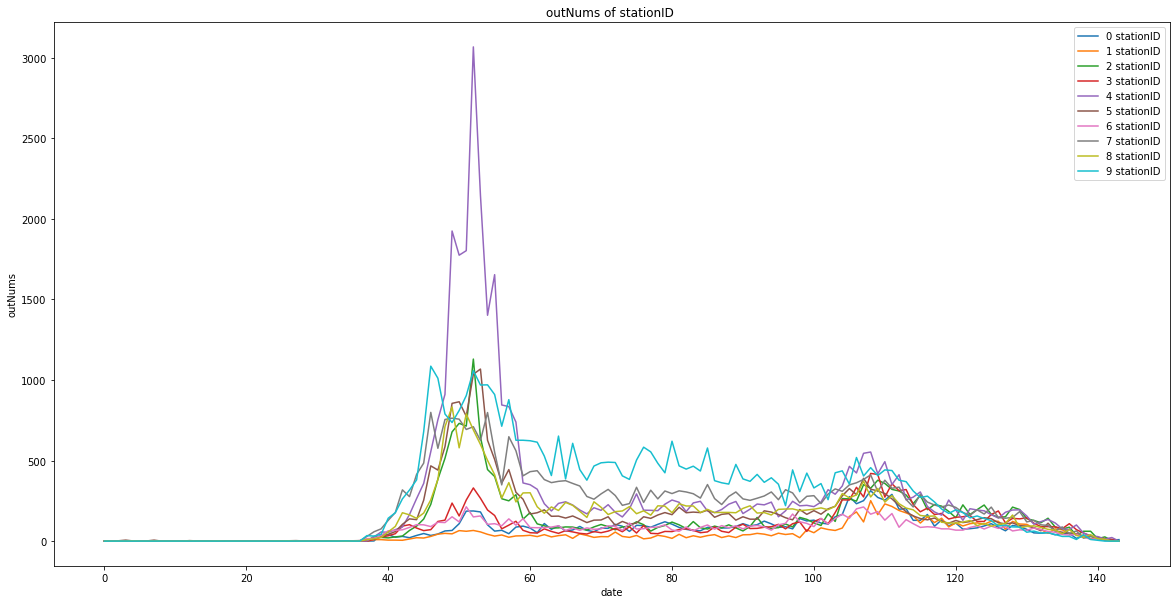

In [30]:
tmp = df_data[df_data.day==3]
dt = [r for r in range(tmp.loc[tmp.stationID==0, 'ten_minutes_in_day'].shape[0])]

fig = plt.figure(1,figsize=[20,10])
plt.ylabel('outNums')
plt.xlabel('date')
plt.title('outNums of stationID ')

for i in range(0,10):
    plt.plot(dt, tmp.loc[tmp.stationID==i, 'outNums'], label = str(i)+' stationID' )
    
plt.legend()
plt.show()

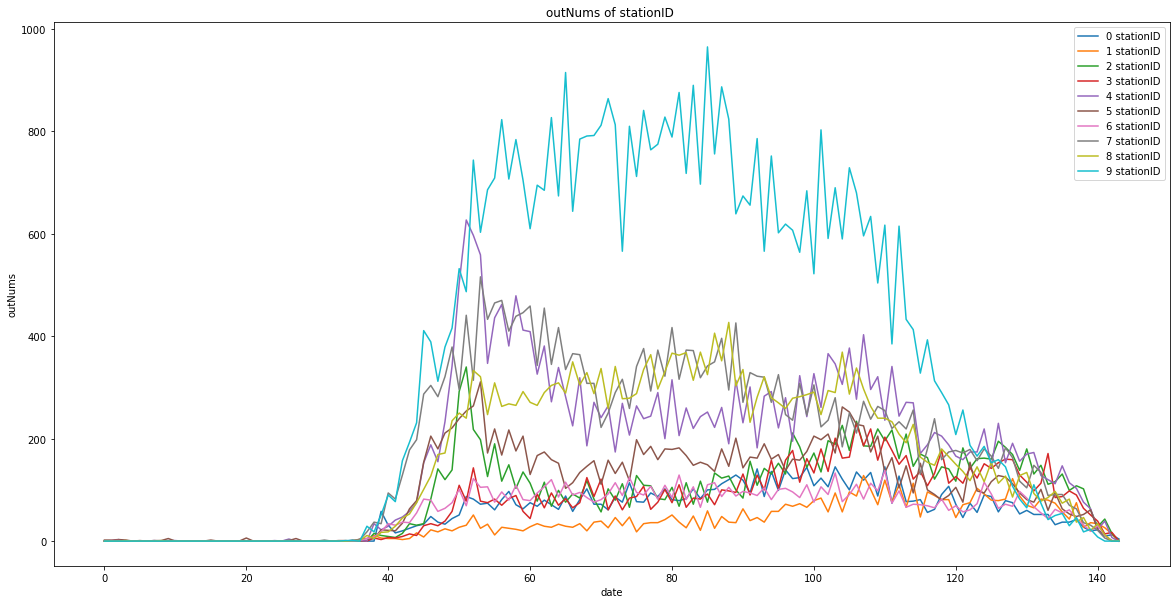

In [31]:
tmp = df_data[df_data.day==5]
dt = [r for r in range(tmp.loc[tmp.stationID==0, 'ten_minutes_in_day'].shape[0])]

fig = plt.figure(1,figsize=[20,10])
plt.ylabel('outNums')
plt.xlabel('date')
plt.title('outNums of stationID ')

for i in range(0,10):
    plt.plot(dt, tmp.loc[tmp.stationID==i, 'outNums'], label = str(i)+' stationID' )
    
plt.legend()
plt.show()

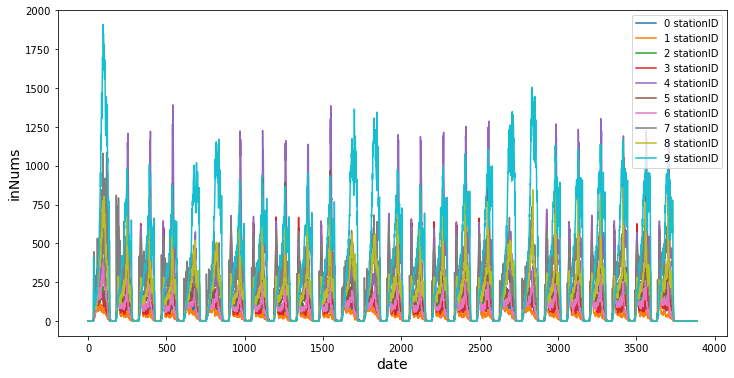

In [33]:
tmp = df_data[df_data.day>=1]
dt = [r for r in range(tmp.loc[tmp.stationID==0, 'ten_minutes_in_day'].shape[0])]

fig = plt.figure(1,figsize=[12,6])
plt.ylabel('inNums',fontsize=14)
plt.xlabel('date',fontsize=14)
# plt.title('inNums of stationID ')

for i in range(0,10):
    plt.plot(dt, tmp.loc[tmp.stationID==i, 'inNums'], label = str(i)+' stationID' )
    
plt.legend()

周期性比较强，围绕着天进行，或者周



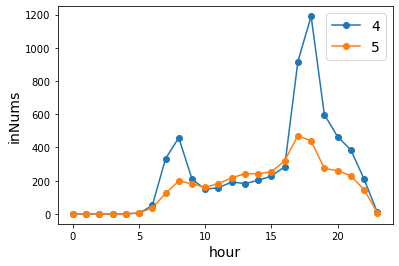

In [34]:
tmp = df_data.loc[(df_data.day.isin([4,5]))] # 4为周内，5为周末
tmp.loc[tmp.stationID == 4].pivot_table(index='hours_in_day',\
                                        columns='day',values='inNums').plot(style='o-')

plt.ylabel('inNums',fontsize=14)
plt.xlabel('hour',fontsize=14)
plt.legend(fontsize=14)

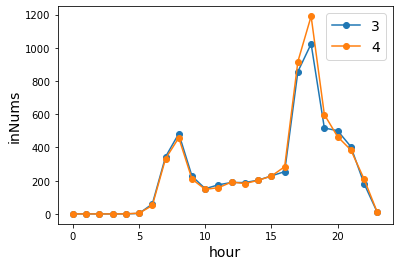

In [35]:
tmp = df_data.loc[(df_data.day.isin([3,4]))]
tmp.loc[tmp.stationID == 4].pivot_table(index='hours_in_day',\
                                        columns='day',values='inNums').plot(style='o-')

plt.ylabel('inNums',fontsize=14)
plt.xlabel('hour',fontsize=14)
plt.legend(fontsize=14)

In [36]:
df_data.loc[df_data.day==1, 'day'] = '元旦'


In [37]:
plt.rcParams['font.sans-serif'] = ['Heiti TC']
plt.rcParams['axes.unicode_minus'] = False

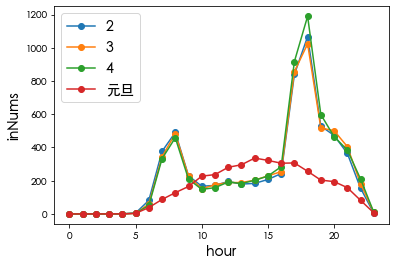

In [38]:
tmp = df_data.loc[(df_data.day.isin(['元旦',2,3,4]))]
tmp.loc[tmp.stationID == 4].pivot_table(index='hours_in_day',\
                                        columns='day',values='inNums').plot(style='o-')

plt.ylabel('inNums',fontsize=14)
plt.xlabel('hour',fontsize=14)
plt.legend(fontsize=14)
plt.savefig("10_inNums_of_day1234.svg", format="svg")

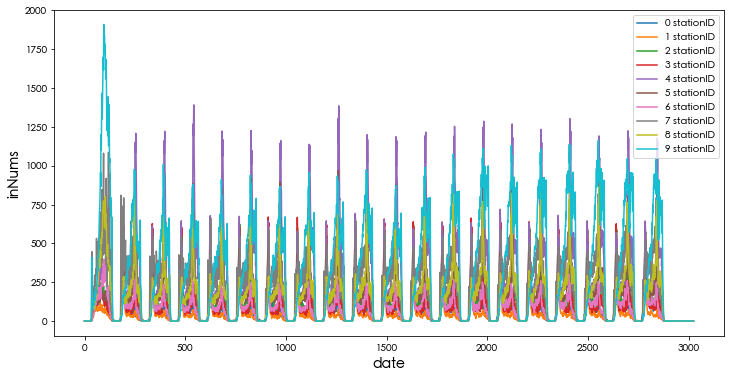

In [39]:
# 剔除与测试集分布差异大的日期
df_data = df_data.loc[((df_data.day_of_week < 5) & (df_data.day != 1))].copy()
# 保留日期
retain_days = list(df_data.day.unique())
# 重新计算rank，方便我们后续提取特征
days_relative = {} 
for i,d in enumerate(retain_days):
    days_relative[d] = i + 1

df_data['days_relative'] = df_data['day'].map(days_relative)

#### 可视化代码 ####
dt = [r for r in range(df_data.loc[df_data.stationID==0, 
    'ten_minutes_in_day'].shape[0])]
fig = plt.figure(1,figsize=[12,6])
plt.ylabel('inNums',fontsize=14)
plt.xlabel('date',fontsize=14)

for i in range(0,10):
    plt.plot(dt, df_data.loc[df_data.stationID==i, 'inNums'], label = str(i)+' stationID' )  
plt.legend()